In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

#from imutils import paths
from pathlib import Path
import os, sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

# Local modules
sys.path.append('/home/jupyter/caltech_birds/src')
from train import train_model
from visualize import imshow, visualize_model

In [2]:
def makeTransforms():
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    return data_transforms


In [3]:
# Script runtime options
root_dir = '/home/jupyter/caltech_birds'
data_dir = os.path.join(root_dir,'data','images')

In [4]:
# Get data transforms
data_transforms = makeTransforms()

In [5]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

print('Number of data')
print('========================================')
for dataset in dataset_sizes.keys():
    print(dataset,' size:: ', dataset_sizes[dataset],' images')

print('')
print('Number of classes:: ', len(class_names))
print('========================================')
for i_class, class_name in enumerate(class_names):
    print(i_class,':: ',class_name)


Number of data
train  size::  5994  images
test  size::  5794  images

Number of classes::  200
0 ::  001.Black_footed_Albatross
1 ::  002.Laysan_Albatross
2 ::  003.Sooty_Albatross
3 ::  004.Groove_billed_Ani
4 ::  005.Crested_Auklet
5 ::  006.Least_Auklet
6 ::  007.Parakeet_Auklet
7 ::  008.Rhinoceros_Auklet
8 ::  009.Brewer_Blackbird
9 ::  010.Red_winged_Blackbird
10 ::  011.Rusty_Blackbird
11 ::  012.Yellow_headed_Blackbird
12 ::  013.Bobolink
13 ::  014.Indigo_Bunting
14 ::  015.Lazuli_Bunting
15 ::  016.Painted_Bunting
16 ::  017.Cardinal
17 ::  018.Spotted_Catbird
18 ::  019.Gray_Catbird
19 ::  020.Yellow_breasted_Chat
20 ::  021.Eastern_Towhee
21 ::  022.Chuck_will_Widow
22 ::  023.Brandt_Cormorant
23 ::  024.Red_faced_Cormorant
24 ::  025.Pelagic_Cormorant
25 ::  026.Bronzed_Cowbird
26 ::  027.Shiny_Cowbird
27 ::  028.Brown_Creeper
28 ::  029.American_Crow
29 ::  030.Fish_Crow
30 ::  031.Black_billed_Cuckoo
31 ::  032.Mangrove_Cuckoo
32 ::  033.Yellow_billed_Cuckoo
33 ::  034.

In [6]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


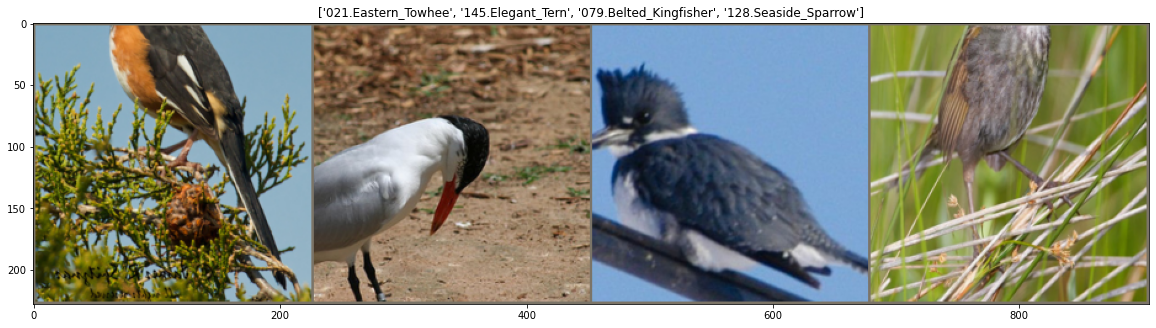

In [7]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
# Setup the model and optimiser
model_ft = models.vgg16(pretrained=True)

In [9]:
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
model_ft.classifier[6].in_features

4096

In [12]:
num_ftrs = model_ft.classifier[6].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
dir(model_ft)

In [ ]:
model_ft = train_model(model=model_ft, criterion=criterion, optimizer=optimizer_ft, scheduler=exp_lr_scheduler, 
                       device=device, dataloaders=dataloaders, dataset_sizes=dataset_sizes, num_epochs=40)

In [ ]:
save_model_full(model=model_ft, PATH='models/classification/caltech_birds_vgg16_full.pth')
save_model_dict(model=model_ft, PATH='models/classification/caltech_birds_vgg16_dict.pth')

In [ ]:
visualize_model(model=model_ft, class_names=class_names, device=device, dataloaders=dataloaders)

In [ ]:
model_ = torch.load('models/classification/caltech_birds_resnext101_full.pth')
model_.eval()

In [ ]:
was_training = model_.training
model_.eval()
images_so_far = 0


print('Commencing predictions minibatch..', end='')
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        if i % 25 == 0:
            print(i,'..', end='')

        inputs = inputs.to(device)
        labels = labels.to(device)
        

        outputs = model_(inputs)
        _, preds = torch.max(outputs, 1)

        if i == 0:
            labels_truth = labels.cpu().numpy()
            labels_pred = preds.cpu().numpy()
        else:
            labels_truth = np.concatenate((labels_truth,labels.cpu().numpy()))
            labels_pred = np.concatenate((labels_pred,preds.cpu().numpy()))

print('Complete.')



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [ ]:
pd.DataFrame(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names, output_dict=True))

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true=labels_truth, y_pred=labels_pred), index=class_names, columns=class_names)